In [23]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook
import imageio
import skimage

# Util function for loading meshes
from pytorch3d.io import load_obj, save_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader,
    SoftSilhouetteShader,
    BlendParams
)
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from utils import *
import json
import cv2
import numpy as np
import math
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))


from datetime import datetime
import os
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
print(now_str())
%load_ext autoreload
%autoreload 2

[03/25 22:39:44]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

# load verts and texture
img_name = '18333'
verts, faces_idx, _ = load_obj('./1_obj/A000{}.obj'.format(img_name))

# rotate R 180 degree around viewing axis
# cos180 = math.cos(np.pi)
# sin180 = math.sin(np.pi)
# # R_z180 = torch.from_numpy(np.array([[cos180, -sin180, 0], [sin180, cos180, 0], [0, 0, 1]]))
# R_y180 = torch.from_numpy(np.array([[cos180, 0, sin180], [0, 1, 0], [-sin180, 0, cos180]]))
# verts = verts.unsqueeze(-1).double()
# R_y180 = R_y180.unsqueeze(0)
# R_y180 = R_y180.unsqueeze(0).double()
# print(verts.shape)
# print(R_y180.shape)
# verts = torch.matmul(R_y180, verts).squeeze().float()
faces = faces_idx.verts_idx

# no texture for now
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
verts_rgb[0, :, 0] = verts_rgb[0, :, 0] * 0.5
textures = Textures(verts_rgb=verts_rgb.to(device))

# create mesh bobject
person_mesh = Meshes(verts=[verts.to(device)], faces=[faces.to(device)], textures=textures)
print(person_mesh)
texture_image = person_mesh.textures.verts_rgb_packed()

In [3]:
plt.figure(figsize=(7,7))
print(texture_image.squeeze().cpu().numpy().shape)
plt.imshow(texture_image.squeeze().cpu().numpy(), cmap='gray')
plt.grid("off");
plt.axis('off');

(1692, 3)


# Renderer

### camera extrinsics

In [4]:
in_path = r'D:\CalibrationData\CameraCalibration\2020_01_01_KateyCapture_k1k2k3p1p2\FinalCamParams\cam_params.json'
with open(in_path, 'r') as f:
    j = json.load(f)
    cam_params = j['cam_params']

In [218]:
cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cam_idx = 10
cam_param = cam_params[str(cam_idx)]
rvec = np.float32(cam_param['rvec'])
T = np.float32(cam_param['tvec'])

R, _ = cv2.Rodrigues(rvec)
# T = -R.T.dot(T)
R = R.T

# R = R.dot(R_z180)
R = torch.from_numpy(R).unsqueeze(0)
T = torch.from_numpy(T).unsqueeze(0)
print(R.shape)
print(T.shape)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
image_size = 512
raster_settings = RasterizationSettings(
    image_size=image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

# Place a point light in front of the object
lights = PointLights(device=device, location=[[2000.0, 2000.0, 2000.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, lights=lights
    )
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# image
img_dir = r'Z:\2020_01_01_KateyCapture\Converted'
image_studio = cv2.imread(img_dir + '\\{}\{}{}.pgm'.format(cams[cam_idx], cams[cam_idx], img_name), cv2.IMREAD_GRAYSCALE)
print(image_studio.shape)

# silhouette image
# v1
image_ref = cv2.imread('./2_input/J18333_silhouette.jpg', cv2.IMREAD_GRAYSCALE)
scale = image_size / image_ref.shape[0]
width = int(image_ref.shape[1] * scale)
height = int(image_ref.shape[0] * scale)
dim = (width, height)
print(dim)
image_ref = cv2.resize(image_ref, dim)
cy = image_ref.shape[1] / 2
image_ref = image_ref[:, int(cy-image_size/2):int(cy+image_size/2)]
image_ref = cv2.flip(image_ref, -1) / 255.0
image_ref = torch.from_numpy(image_ref).cuda()
print(image_ref.shape)

# v2
# image_ref = silhouette_renderer(meshes_world=person_mesh)
# image_ref = image_ref.squeeze()[..., 3]

torch.Size([1, 3, 3])
torch.Size([1, 3])
(2160, 4000)
(948, 512)
torch.Size([512, 512])


(512, 512) , 0.77883536
(512, 512) , 1.0


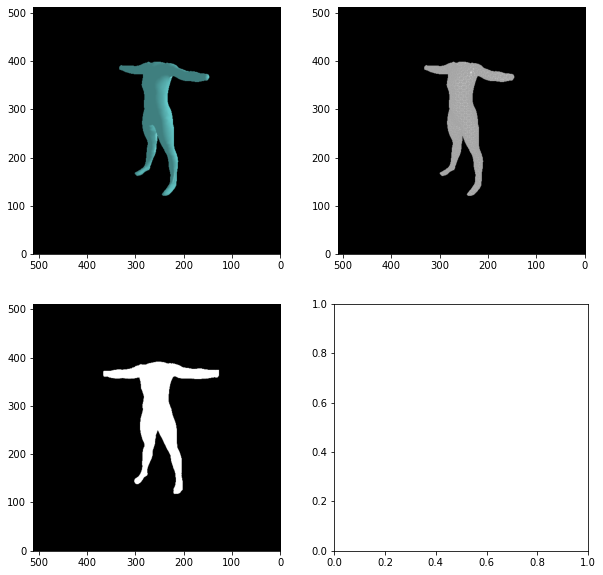

In [219]:
image_init = phong_renderer(meshes_world=person_mesh)
silhouete = silhouette_renderer(meshes_world=person_mesh)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(image_init.cpu().numpy().squeeze())
ax[0].invert_yaxis()
ax[0].invert_xaxis()

silhouette_alpha = silhouete.cpu().numpy().squeeze()[...,3 ]
ax[1].imshow(silhouette_alpha, cmap='gray')
ax[1].invert_yaxis()
ax[1].invert_xaxis()

image_ref_alpha = image_ref.cpu().numpy().squeeze()
ax[2].imshow(image_ref_alpha, cmap='gray')
ax[2].invert_yaxis()
ax[2].invert_xaxis()

print(silhouette_alpha.shape,',', np.max(silhouette_alpha))
print(image_ref_alpha.shape,',', np.max(image_ref_alpha))

<!-- # Model -->

# Optimizations

In [220]:
class Model(nn.Module):
    def __init__(self, meshes, phong_renderer, silhouette_renderer, image_ref, w_silhoutte, w_normal, w_laplacian):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.silhouette_renderer = silhouette_renderer
        self.phong_renderer = phong_renderer
        self.register_buffer('image_ref', image_ref)
        #self.deform_verts = torch.full(self.meshes.verts_packed().shape, 0.0, device=meshes.device, requires_grad=True)
        self.deform_verts = nn.Parameter(
            torch.from_numpy(np.zeros(self.meshes.verts_packed().shape, dtype=np.float32)).to(meshes.device))

        self.w_silhoutte = w_silhoutte
        self.w_normal = w_normal
        self.w_laplacian = w_laplacian
    def forward(self, render_phong=False):
        deformed_mesh = self.meshes.offset_verts(self.deform_verts)
        image_silhoutte = self.silhouette_renderer(meshes_world=deformed_mesh.clone())
        image_silhoutte = image_silhoutte.masked_fill((image_silhoutte > 0.8), 1)

        if render_phong:
            image_phong = self.phong_renderer(meshes_world=deformed_mesh)
        else:
            image_phong = None
            
        # Calculate the silhouette loss
        image_silhoutte_alpha = image_silhoutte[..., 3]
        image_ref_alpha = self.image_ref
        loss_sil = torch.sum((image_silhoutte_alpha - image_ref_alpha) ** 2)
        
        loss_normal = mesh_normal_consistency(self.meshes)
        
        loss_laplacian = mesh_laplacian_smoothing(self.meshes, method='uniform')
        
        loss = self.w_silhoutte*loss_sil + self.w_normal*loss_normal + self.w_laplacian*loss_laplacian
        return loss, image_silhoutte, image_phong, loss_sil, loss_normal, loss_laplacian
    
def render_images(imgL, imgR, titleL='', titleR=''):
    plt.subplot(1, 2, 1)
    plt.imshow(imgL)
    plt.grid(False)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.title(titleL)
    plt.grid("off")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(imgR)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.grid(False)
    plt.title(titleR)
    plt.grid("off")
    plt.axis("off")
    plt.show()
    
def render_images3(img1, img2, img3, title1='', title2='', title3=''):
    plt.subplot(1, 3, 1)
    plt.imshow(img1), plt.title(title1)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.grid("off"), plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(img2), plt.title(title2)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.grid("off"), plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(img3), plt.title(title3)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.grid("off"), plt.axis("off")
    plt.show()

8129.038951111088 | 8121.964531381094 | 0.06272724 | 28.29517


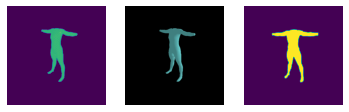

0.8812927
0.77883536
1.0


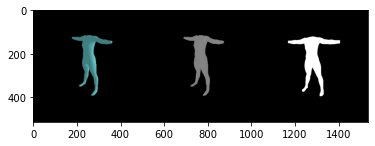

In [230]:
w_sil = 1.0
w_normal = 0.01
w_laplacian = 0.25
model = Model(meshes=person_mesh.clone(), phong_renderer=phong_renderer, silhouette_renderer=silhouette_renderer, image_ref=image_ref, w_silhoutte=w_sil, w_normal=w_normal, w_laplacian=w_laplacian).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss0, image0_sil, image0_phong, loss0_sil, loss0_norm, loss0_lap = model(render_phong=True)
print(loss0.detach().cpu().numpy(), '|', loss0_sil.detach().cpu().numpy(), '|', loss0_norm.detach().cpu().numpy(), '|', loss0_lap.detach().cpu().numpy())


image0_sil_ = image0_sil[...,3].detach().squeeze().cpu().numpy()
image0_phong_ = image0_phong[0, ..., :3].detach().squeeze().cpu().numpy()
image_ref_ = image_ref.detach().squeeze().cpu().numpy()
render_images3(image0_sil_, image0_phong_, image_ref_)

img1 = image0_phong[0, ..., :3].detach().squeeze().cpu().numpy()
img2 = image0_sil[0, ..., 3].detach().squeeze().cpu().numpy()
img2 = np.array([img2.T, img2.T, img2.T]).transpose()
img3 = np.array([image_ref_.T, image_ref_.T, image_ref_.T]).transpose()

img1 = cv2.flip(img1, -1)
img2 = cv2.flip(img2, -1)
img3 = cv2.flip(img3, -1)
img4 = np.hstack([img1, img2, img3])

print(np.max(img1))
print(np.max(img2))
print(np.max(img3))
plt.figure()
plt.imshow(img4)

<ipython-input-231-4e1dd9c71fca>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(100000))


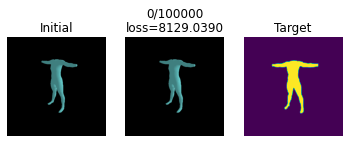

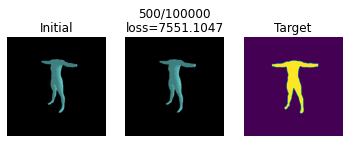

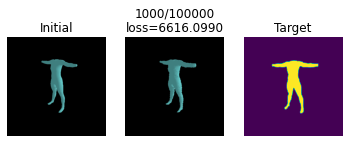

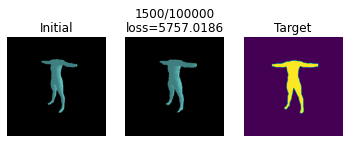

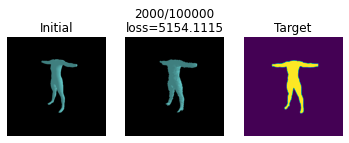

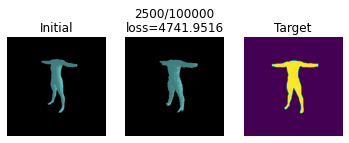

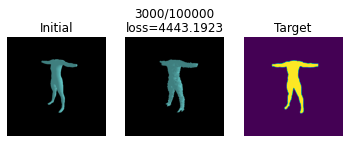

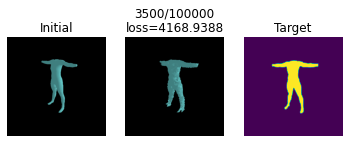

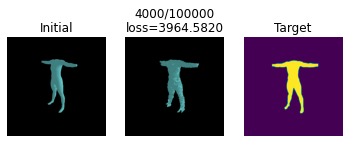

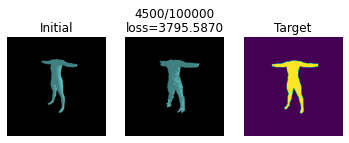

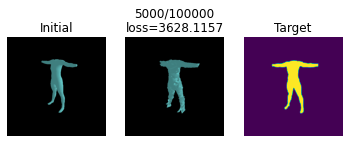

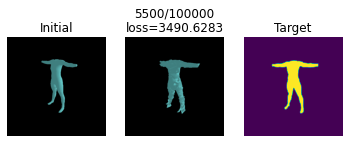

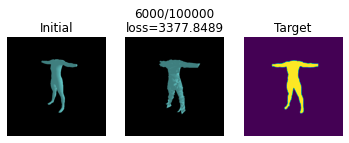

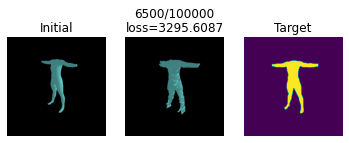

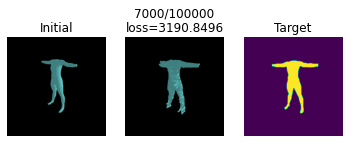

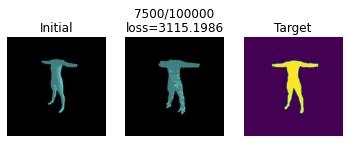

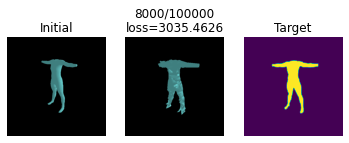

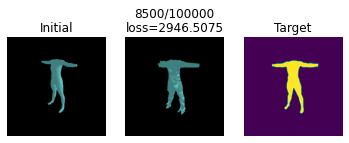

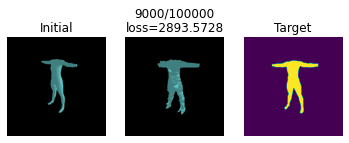

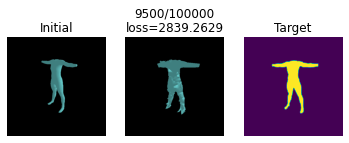

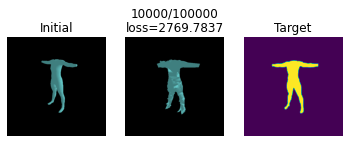

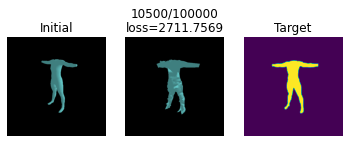

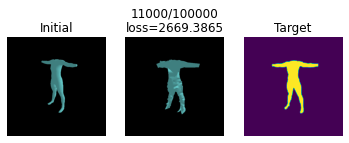

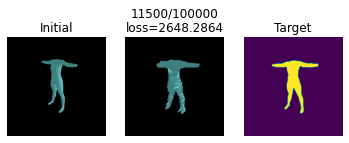

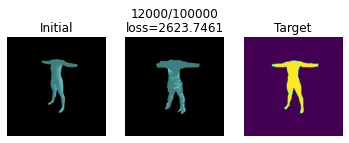

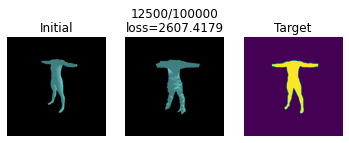

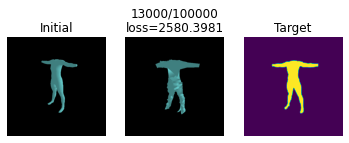

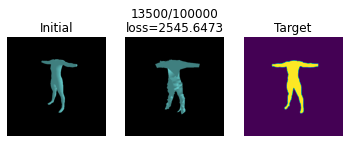

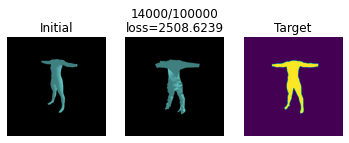

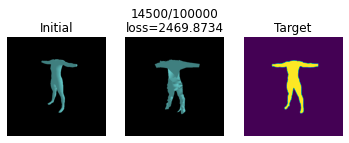

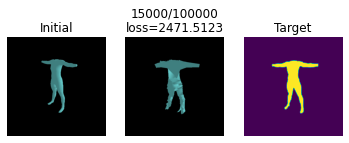

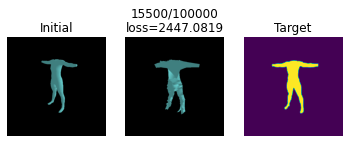

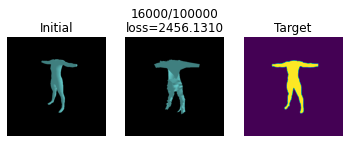

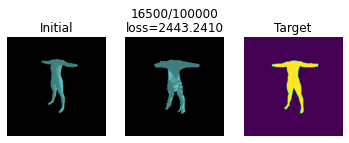

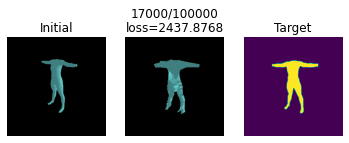

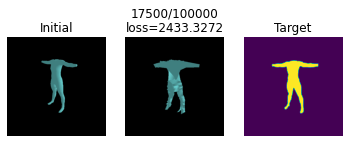

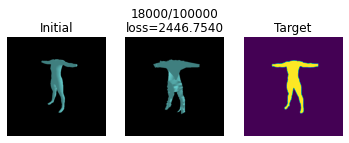

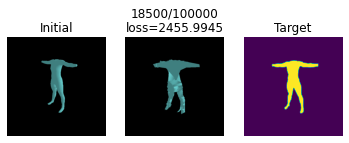

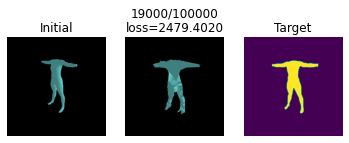

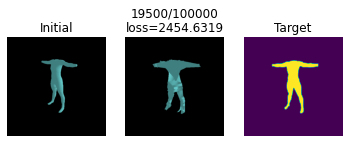

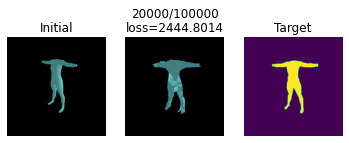

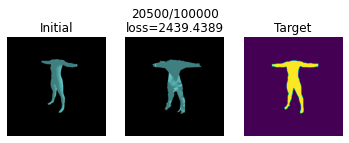

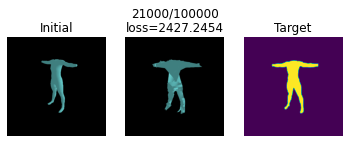

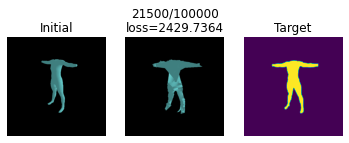

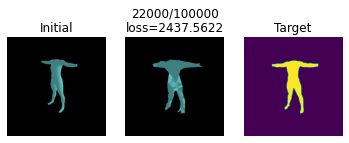

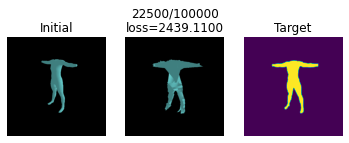

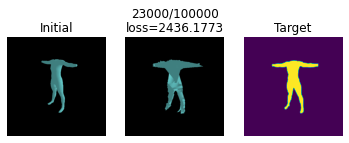

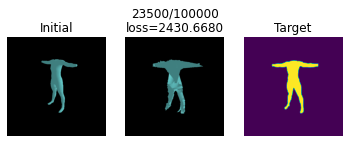

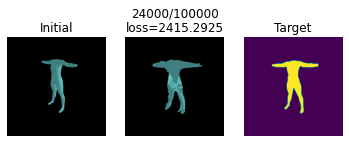

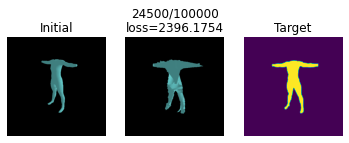

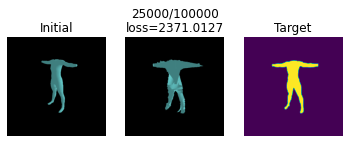

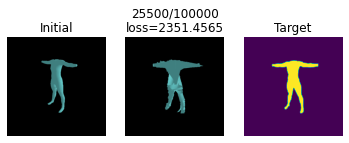

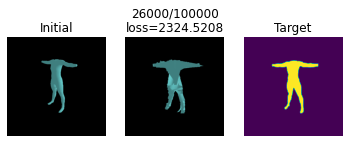

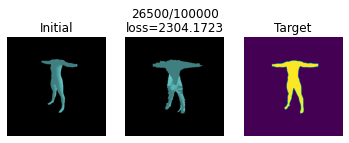

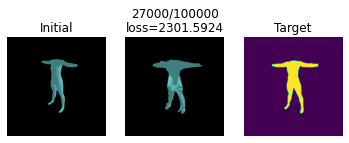

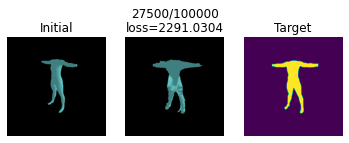

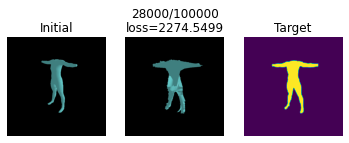

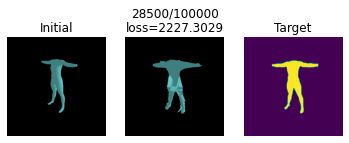

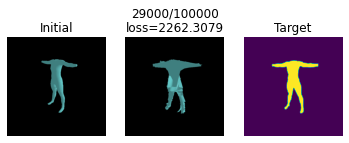

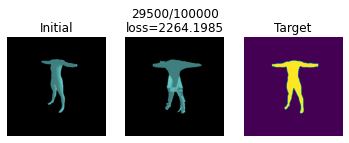

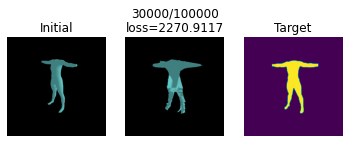

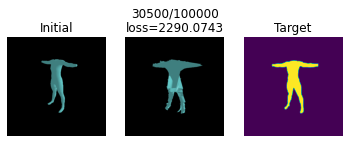

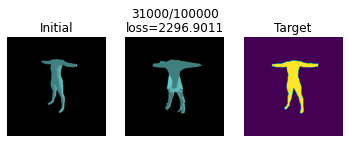

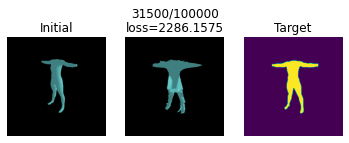

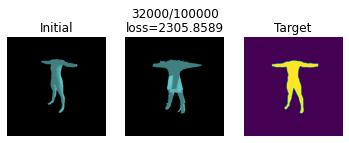

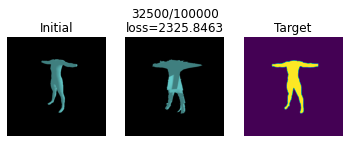

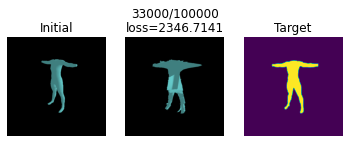

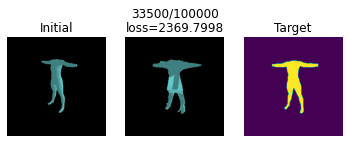

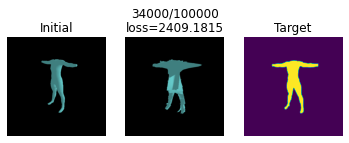

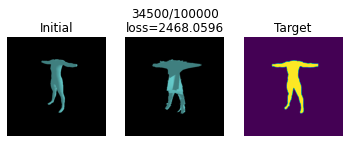

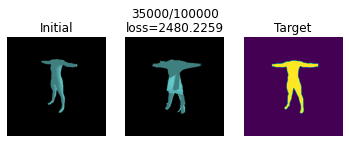

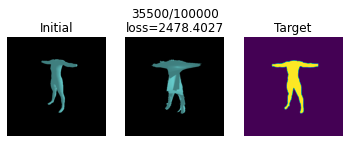

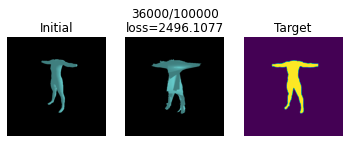

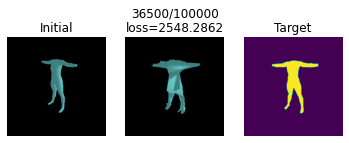

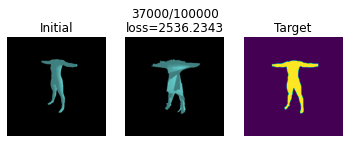

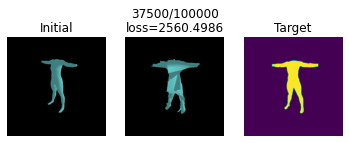

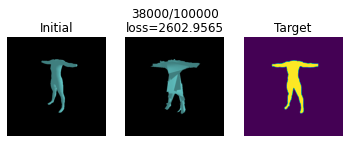

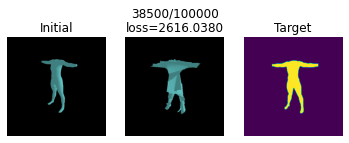

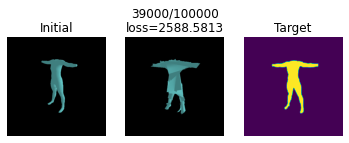

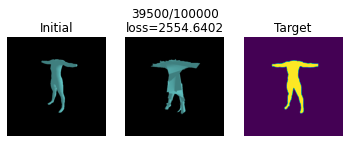

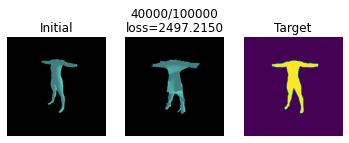

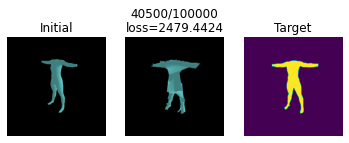

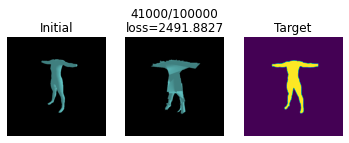

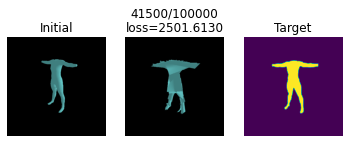

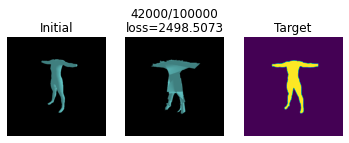

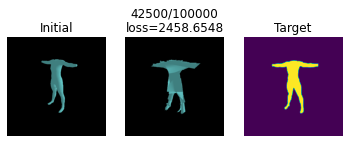

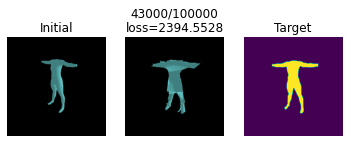

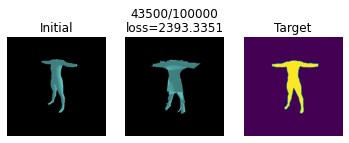

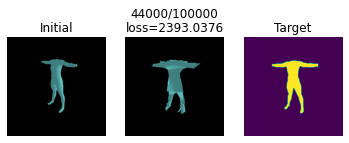

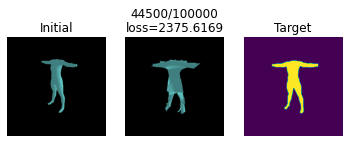

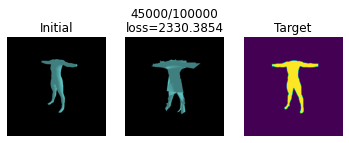

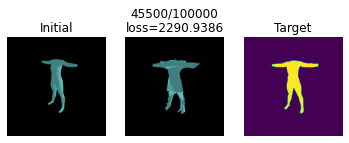

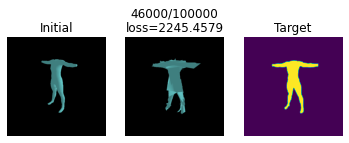

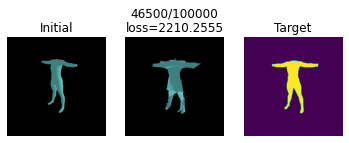

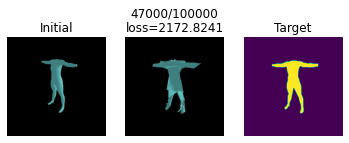

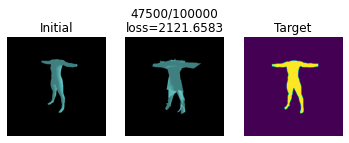

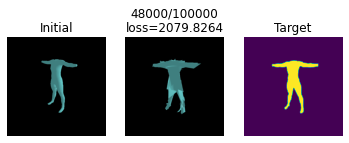

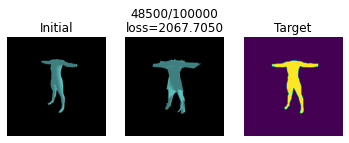

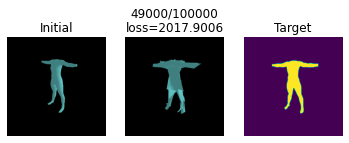

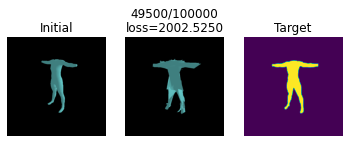

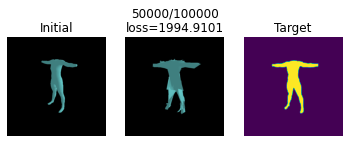

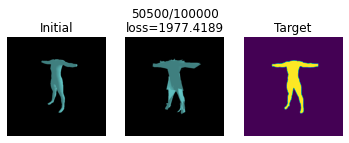

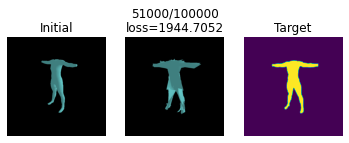

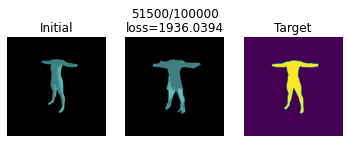

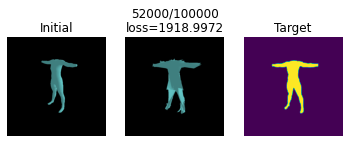

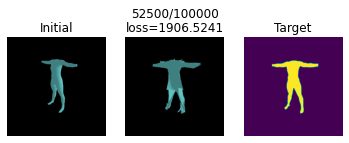

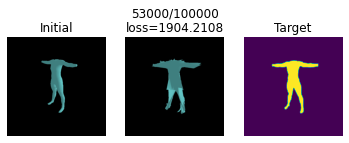

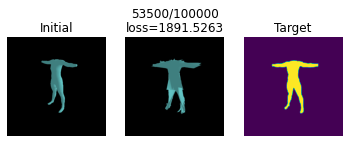

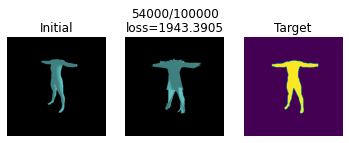

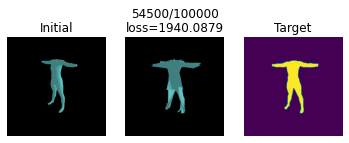

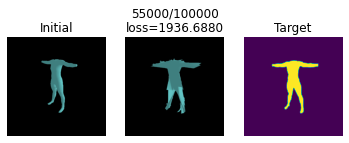

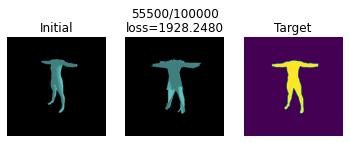

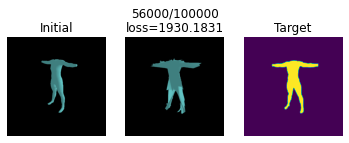

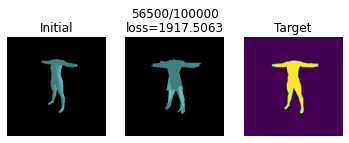

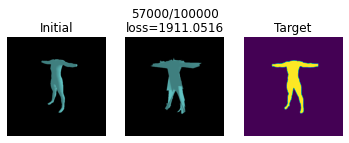

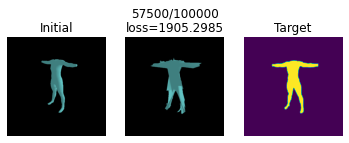

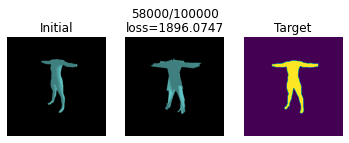

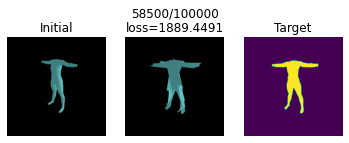

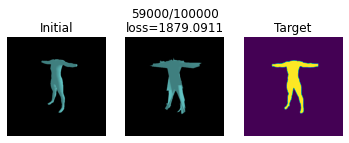

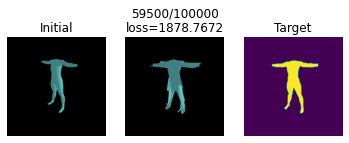

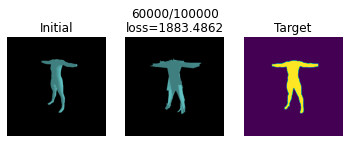

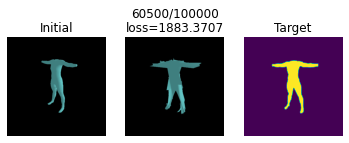

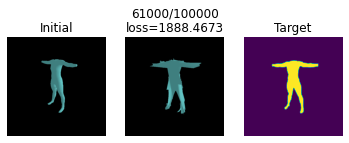

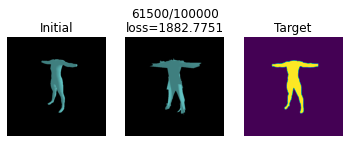

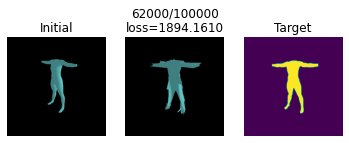

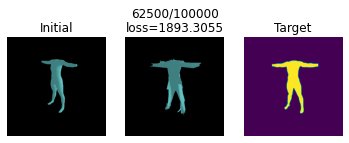

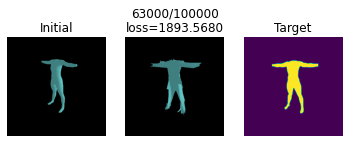

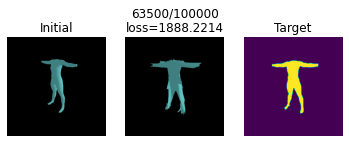

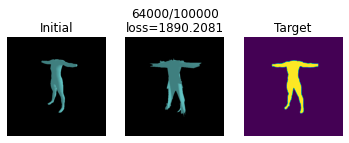

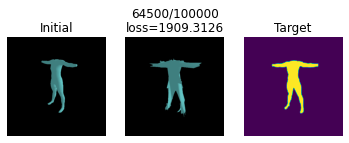

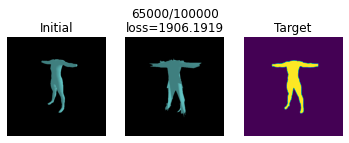

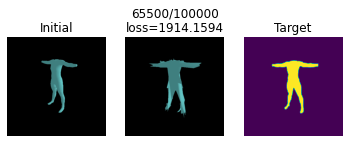

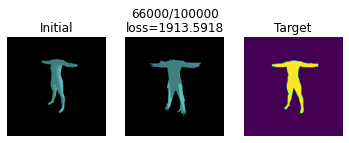

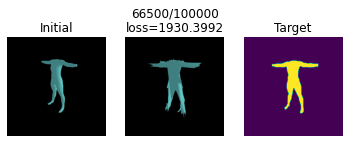

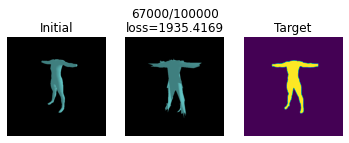

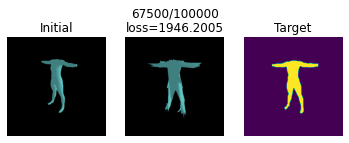

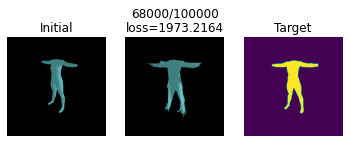

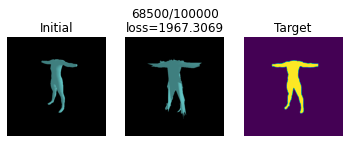

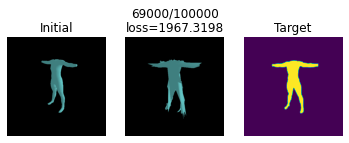

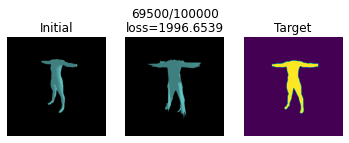

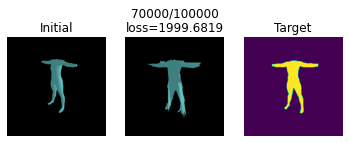

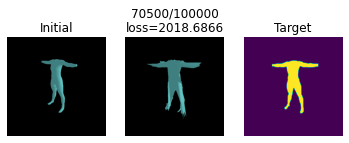

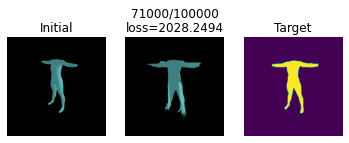

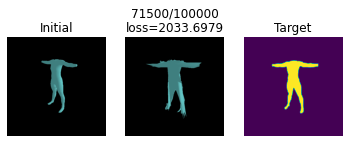

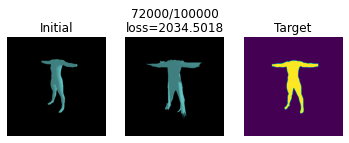

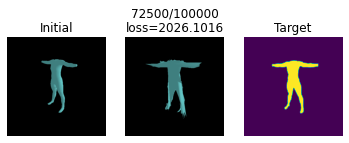

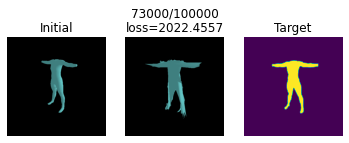

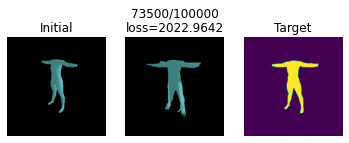

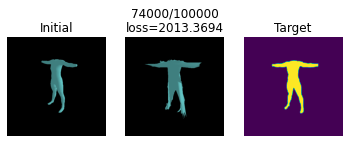

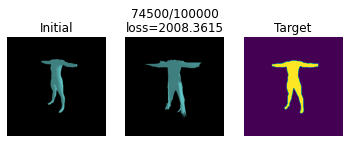

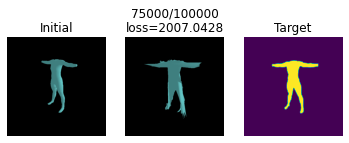

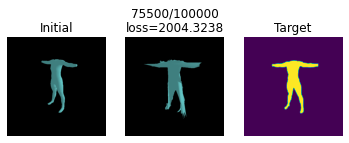

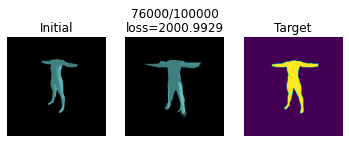

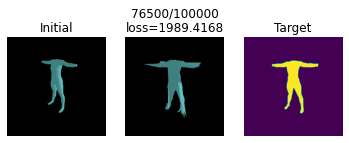

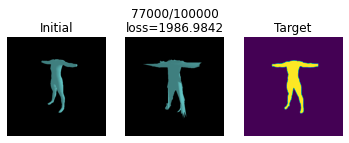

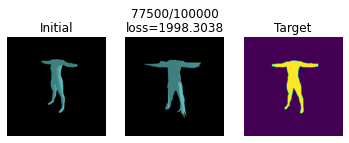

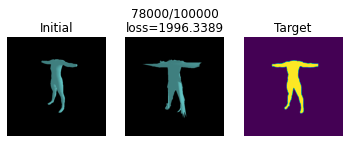

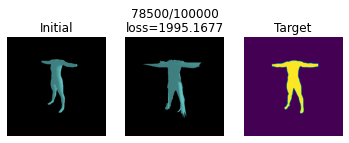

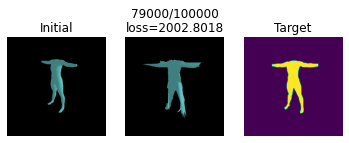

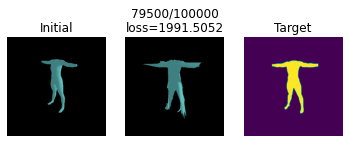

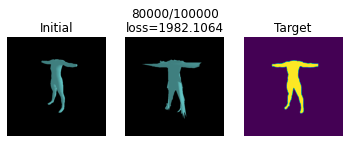

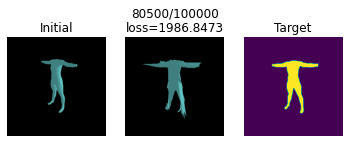

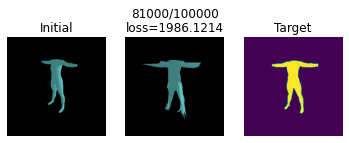

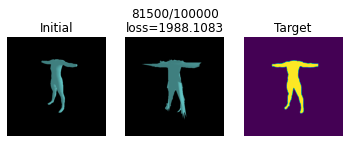

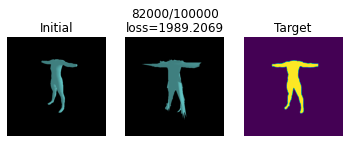

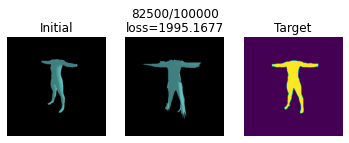

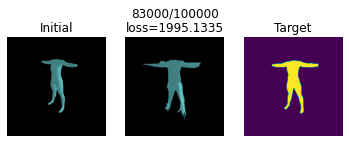

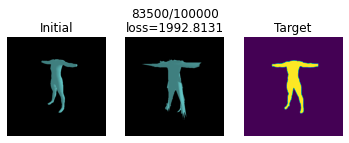

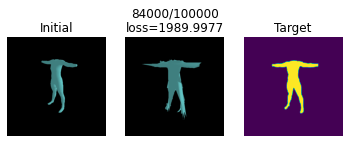

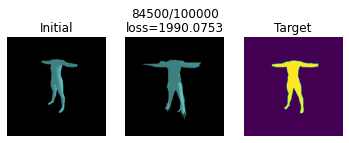

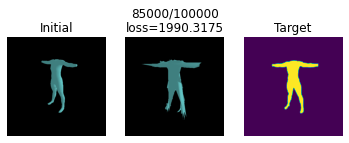

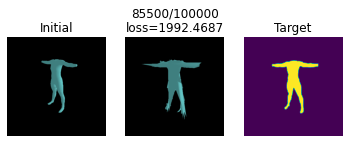

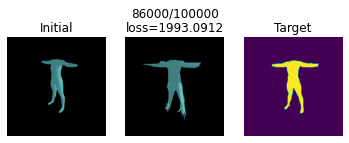

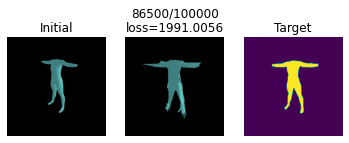

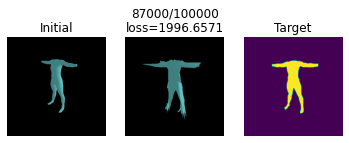

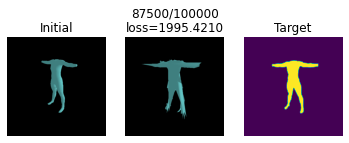

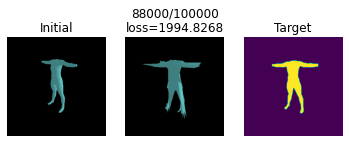

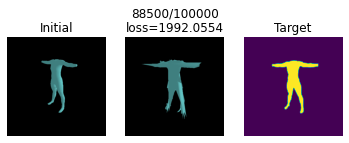

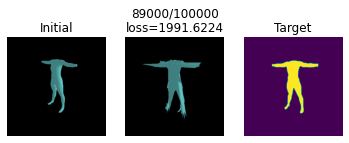

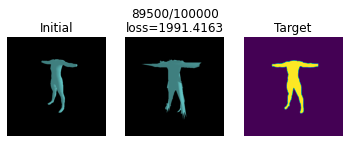

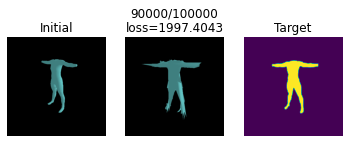

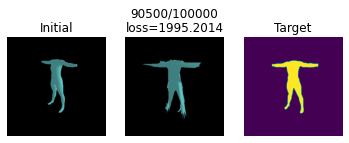

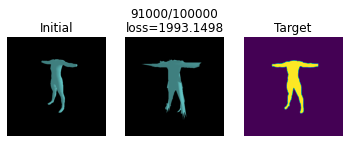

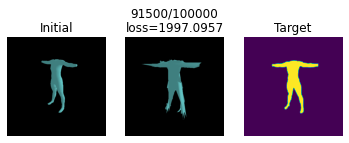

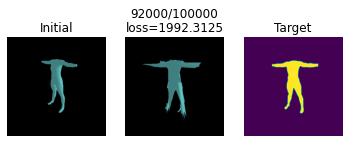

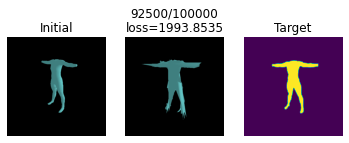

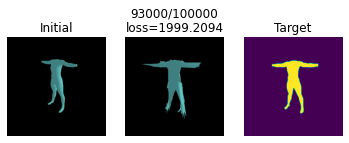

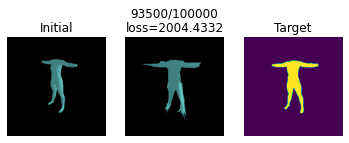

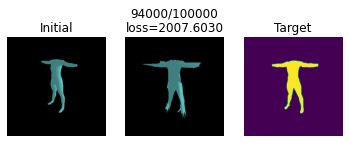

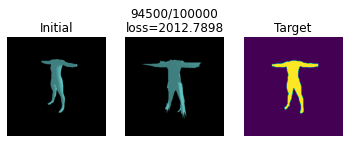

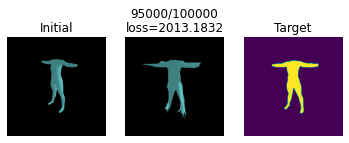

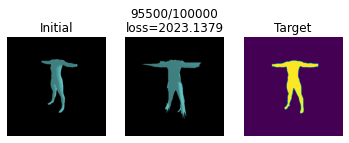

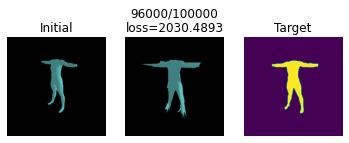

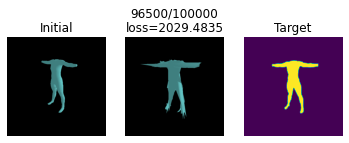

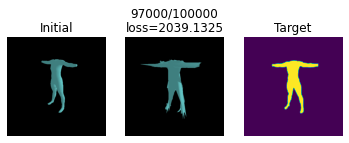

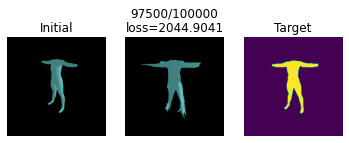

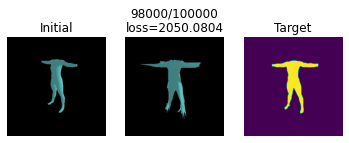

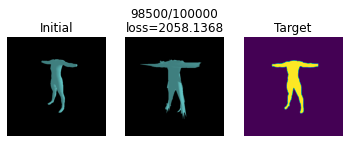

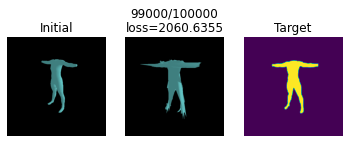

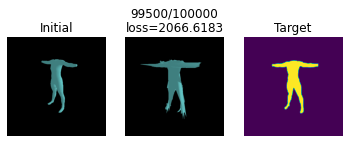

In [231]:
# timestamp
now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}_{:>02}h{:>02}m'.format(now.year, now.month, now.day, hour, minute)
filename_output = "./2_output/{}.gif".format(date_str)
writer = imageio.get_writer(filename_output, mode='I', duration=0.1)

loop = tqdm_notebook(range(100000))    

losses = {'total_loss': [], 'loss_sil': [], 'loss_normal': [], 'loss_laplacian': []}
for i in loop:
    mark = i % 500 == 0
    optimizer.zero_grad()
    if mark:
        loss, img_sil, img_pho, l_sil, l_norm, l_lap = model(render_phong=True)
    else:
        loss, _, _, _, _, _ = model(render_phong=False)
    
    loop.set_description('[{}/{}] loss {:.6f}'.format(i, len(loop), loss.data))
    loss.backward()
    optimizer.step()
    
    if mark:
        losses['total_loss'].append(loss)
        losses['loss_sil'].append(l_sil)
        losses['loss_normal'].append(l_norm)
        losses['loss_laplacian'].append(l_lap)
        
        img_pho = img_pho[0, ..., :3].detach().squeeze().cpu().numpy()
        img2 = cv2.flip(img_pho, -1)
        image_out = np.hstack([img1, img2, img3])
        image_out = skimage.img_as_ubyte(image_out)
        writer.append_data(image_out)
        render_images3(image0_phong_, img_pho, image_ref_, title1='Initial', title2='{}/{}\nloss={:.4f}'.format(i, len(loop), loss), title3='Target')
    
#     if len(losses['total_loss']) > 2:
#         if abs(losses['total_loss'][-2] - losses['total_loss'][-1]) < 0.01:
#             break
        
writer.close()   

In [227]:
writer.close()

# Plot

Text(0.5, 1.0, 'Loss vs iterations')

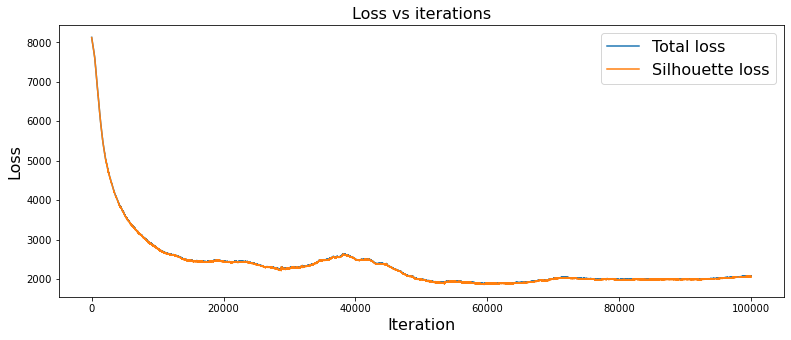

In [236]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(losses['total_loss'], label="Total loss")
ax.plot(losses['loss_sil'], label="Silhouette loss")
# ax.plot(losses['loss_normal'], label="Normal loss")
# ax.plot(losses['loss_laplacian'], label="Laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")

In [ ]:
_, image_final = model()

image_final = image_final.detach().squeeze().cpu().numpy()
render_images(image_init[..., 3], image_final[..., 3])
plt.subplot(1, 2, 1)
plt.imshow(image_init[..., 3])
plt.grid(False)
plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
plt.title("Initial position")

plt.subplot(1, 2, 2)
plt.imshow(image_final[..., 3])
plt.grid(False)
plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
plt.title("Final position")